In [1]:
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pyemma
import deeptime as dt
import mdtraj as md
import networkx as nx
from timescales import implied_timescales_msm
from copy import deepcopy
import nglview as nv
from sklearn.neighbors import KernelDensity
from scipy.spatial.distance import cosine

In [2]:
fake_trj_fname = 'ADP_testset/hallucinated.dcd'
fake_top_fname = 'ADP_testset/AA.pdb'

real_trj_fname = 'ADP_testset/AA.dcd'
real_top_fname = 'ADP_testset/AA.pdb'

# REAL

In [3]:
pdb = real_top_fname
files = real_trj_fname
num_timescales=16
lagtime = 1

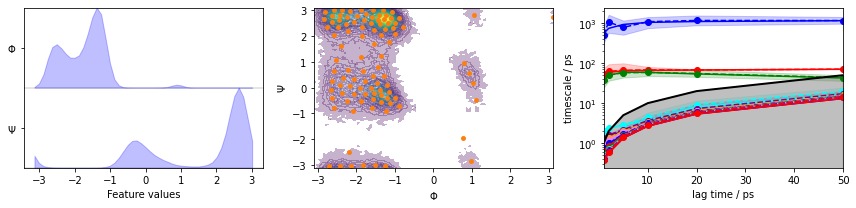

In [4]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)

projected_data = data

cluster = dt.clustering.KMeans(100, max_iter=500).fit(projected_data).fetch_model()
dtrajs = cluster.transform(projected_data)

#its_result = implied_timescales_msm(dtrajs, lagtimes=[1, 2, 5, 10, 20, 50], nits=num_timescales)
its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(projected_data, 
                                     feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*projected_data.T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()
plt.show()

fraction of states used = 1.000000
fraction of counts used = 1.000000


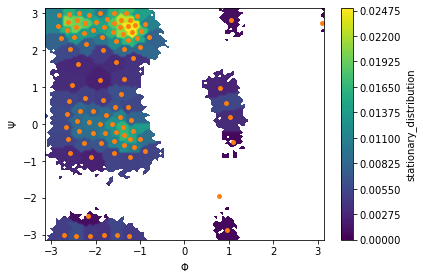

In [5]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(dtrajs).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *projected_data.T, msm.stationary_distribution[dtrajs],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.9999999999985845, max=1.0000000000000697)


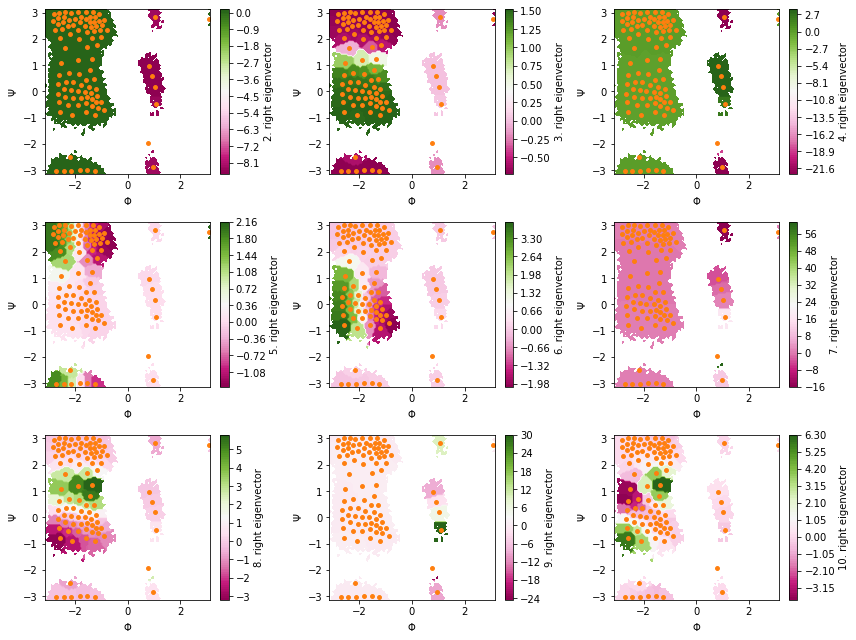

In [6]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *projected_data.T, eigvec[dtrajs, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

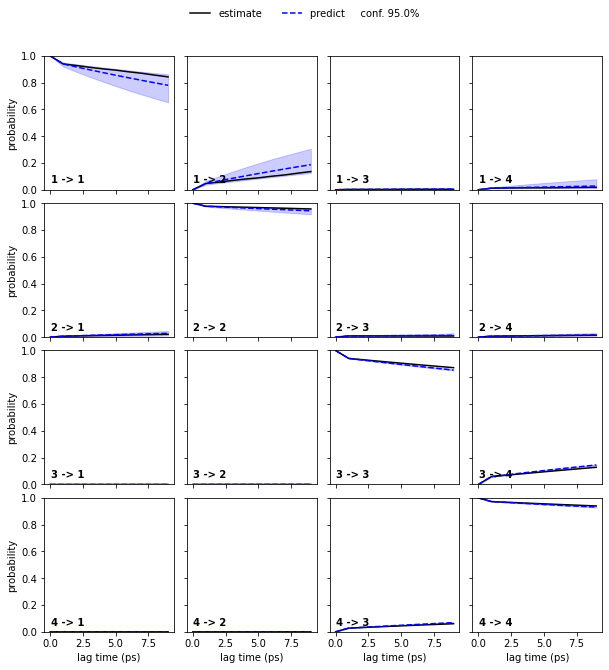

In [7]:
counts = dt.markov.TransitionCountEstimator(lagtime, 'effective').fit(dtrajs).fetch_model()
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts.submodel_largest()).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [8]:
bayesian_msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=lagtime, conf=0.95)
sample_mean = bayesian_msm.sample_mean('timescales', k=num_timescales)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=num_timescales)

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
real_sample_mean = sample_mean
real_sample_conf_l = sample_conf_l
real_sample_conf_r = sample_conf_r

Mean of ITS #0: 457.730305
Confidence interval of ITS #0: [228.626569, 898.050378]
Mean of ITS #1: 54.704678
Confidence interval of ITS #1: [51.819145, 82.595697]
Mean of ITS #2: 37.878963
Confidence interval of ITS #2: [24.320162, 53.474351]
Mean of ITS #3: 2.065973
Confidence interval of ITS #3: [2.042474, 2.088756]
Mean of ITS #4: 1.330556
Confidence interval of ITS #4: [1.307074, 1.357677]
Mean of ITS #5: 1.071348
Confidence interval of ITS #5: [0.981058, 1.318094]
Mean of ITS #6: 0.968122
Confidence interval of ITS #6: [0.856831, 1.013580]
Mean of ITS #7: 0.761630
Confidence interval of ITS #7: [0.668302, 0.861805]
Mean of ITS #8: 0.654999
Confidence interval of ITS #8: [0.638441, 0.669451]
Mean of ITS #9: 0.570793
Confidence interval of ITS #9: [0.561053, 0.602602]
Mean of ITS #10: 0.494580
Confidence interval of ITS #10: [0.477862, 0.572558]
Mean of ITS #11: 0.466948
Confidence interval of ITS #11: [0.446895, 0.492312]
Mean of ITS #12: 0.446641
Confidence interval of ITS #12: [0

In [9]:
evec_real = eigvec
dtrajs_real = dtrajs

# Fake

In [10]:
pdb = fake_top_fname
files = fake_trj_fname

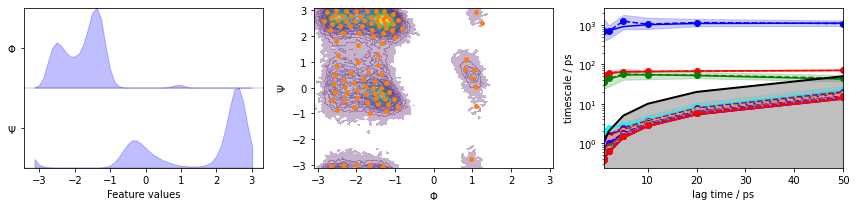

In [11]:
feat = pyemma.coordinates.featurizer(pdb)
feat.add_backbone_torsions(periodic=False)
data = pyemma.coordinates.load(files, features=feat)

projected_data = data

cluster = dt.clustering.KMeans(100, max_iter=500).fit(projected_data).fetch_model()
dtrajs = cluster.transform(projected_data)

#its_result = implied_timescales_msm(dtrajs, lagtimes=[1, 2, 5, 10, 20, 50], nits=num_timescales)
its_result = pyemma.msm.timescales_msm(dtrajs,lags=[1, 2, 5, 10, 20, 50], nits=num_timescales, errors='bayes')

fig, axes = plt.subplots(1, 3, figsize=(12, 3))
pyemma.plots.plot_feature_histograms(projected_data, 
                                     feature_labels=['$\Phi$', '$\Psi$'], ax=axes[0])
pyemma.plots.plot_density(*projected_data.T, ax=axes[1], cbar=False, alpha=0.3)
axes[1].scatter(*cluster.cluster_centers.T, s=15, c='C1')
axes[1].set_xlabel('$\Phi$')
axes[1].set_ylabel('$\Psi$')
pyemma.plots.plot_implied_timescales(its_result, ax=axes[2], units='ps')
fig.tight_layout()
plt.show()

fraction of states used = 1.000000
fraction of counts used = 1.000000


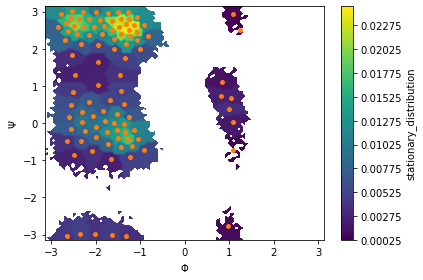

In [12]:
msm = dt.markov.msm.MaximumLikelihoodMSM(lagtime=lagtime).fit(dtrajs).fetch_model()

print('fraction of states used = {:f}'.format(msm.state_fraction))
print('fraction of counts used = {:f}'.format(msm.count_fraction))

fig, ax, misc = pyemma.plots.plot_contour(
    *projected_data.T, msm.stationary_distribution[dtrajs],
    cbar_label='stationary_distribution',
    method='nearest', mask=True)
ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
ax.set_xlabel('$\Phi$')
ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

first eigenvector is one: True (min=0.99999999999992, max=1.0000000000010676)


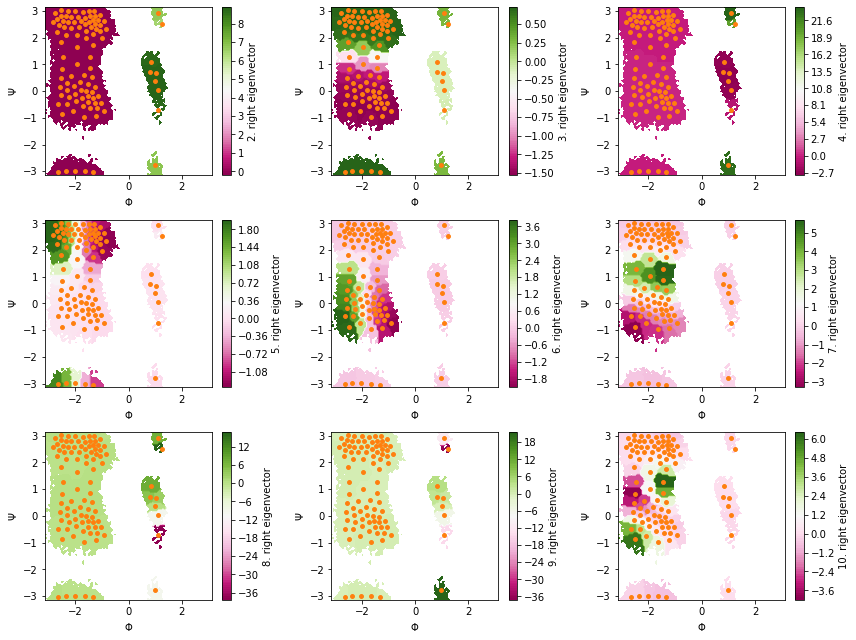

In [13]:
eigvec = msm.eigenvectors_right()
print('first eigenvector is one: {} (min={}, max={})'.format(
    np.allclose(eigvec[:, 0], 1, atol=1e-15), eigvec[:, 0].min(), eigvec[:, 0].max()))

fig, axes = plt.subplots(3, 3, figsize=(12, 9))
for i, ax in enumerate(axes.flat):
    pyemma.plots.plot_contour(
        *projected_data.T, eigvec[dtrajs, i + 1], ax=ax, cmap='PiYG',
        cbar_label='{}. right eigenvector'.format(i + 2), mask=True)
    ax.scatter(*cluster.cluster_centers.T, s=15, c='C1')
    ax.set_xlabel('$\Phi$')
    ax.set_ylabel('$\Psi$')
fig.tight_layout()
plt.show()

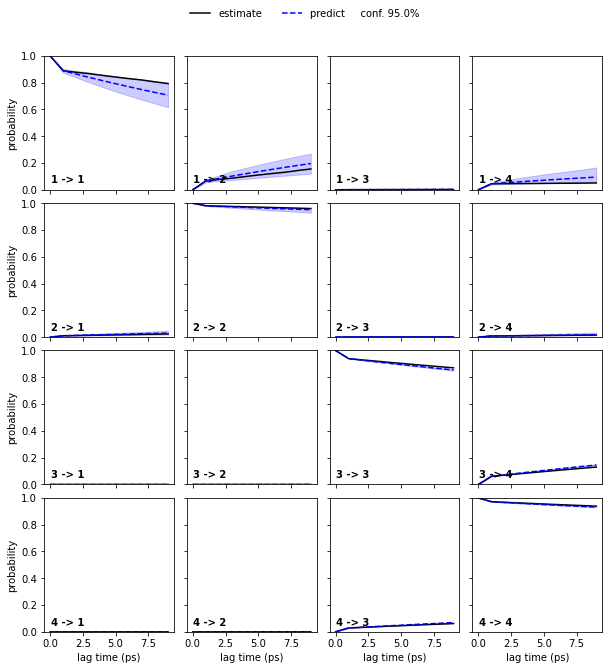

In [14]:
counts = dt.markov.TransitionCountEstimator(lagtime, 'effective').fit(dtrajs).fetch_model()
bayesian_msm_estimator = dt.markov.msm.BayesianMSM()
bayesian_msm = bayesian_msm_estimator.fit(counts.submodel_largest()).fetch_model()

nstates = 4
validator = bayesian_msm_estimator.chapman_kolmogorov_validator(nstates, test_model=bayesian_msm, mlags=10)
cktest = validator.fit(dtrajs).fetch_model()
pyemma.plots.plot_cktest(cktest, units='ps');
plt.show()

In [15]:
bayesian_msm = pyemma.msm.bayesian_markov_model(dtrajs, lag=lagtime, conf=0.95)
sample_mean = bayesian_msm.sample_mean('timescales', k=num_timescales)
sample_conf_l, sample_conf_r = bayesian_msm.sample_conf('timescales', k=num_timescales)

for i in range(num_timescales):
    print('Mean of ITS #{:d}: {:f}'.format(i, sample_mean[i]))
    print('Confidence interval of ITS #{:d}: [{:f}, {:f}]'.format(i, sample_conf_l[i], sample_conf_r[i]))
fake_sample_mean = sample_mean
fake_sample_conf_l = sample_conf_l
fake_sample_conf_r = sample_conf_r

Mean of ITS #0: 736.191325
Confidence interval of ITS #0: [382.569657, 1797.010065]
Mean of ITS #1: 54.659728
Confidence interval of ITS #1: [52.286586, 61.580980]
Mean of ITS #2: 35.444258
Confidence interval of ITS #2: [22.501108, 55.134424]
Mean of ITS #3: 2.070372
Confidence interval of ITS #3: [2.046577, 2.099666]
Mean of ITS #4: 1.327433
Confidence interval of ITS #4: [1.308480, 1.346441]
Mean of ITS #5: 1.015978
Confidence interval of ITS #5: [0.987166, 1.165358]
Mean of ITS #6: 0.930735
Confidence interval of ITS #6: [0.816081, 1.022581]
Mean of ITS #7: 0.762549
Confidence interval of ITS #7: [0.656323, 0.898718]
Mean of ITS #8: 0.656170
Confidence interval of ITS #8: [0.612580, 0.677006]
Mean of ITS #9: 0.570054
Confidence interval of ITS #9: [0.559430, 0.586201]
Mean of ITS #10: 0.502709
Confidence interval of ITS #10: [0.476264, 0.564879]
Mean of ITS #11: 0.472916
Confidence interval of ITS #11: [0.445965, 0.496710]
Mean of ITS #12: 0.447918
Confidence interval of ITS #12: [

In [16]:
evec_fake = eigvec
dtrajs_fake = dtrajs

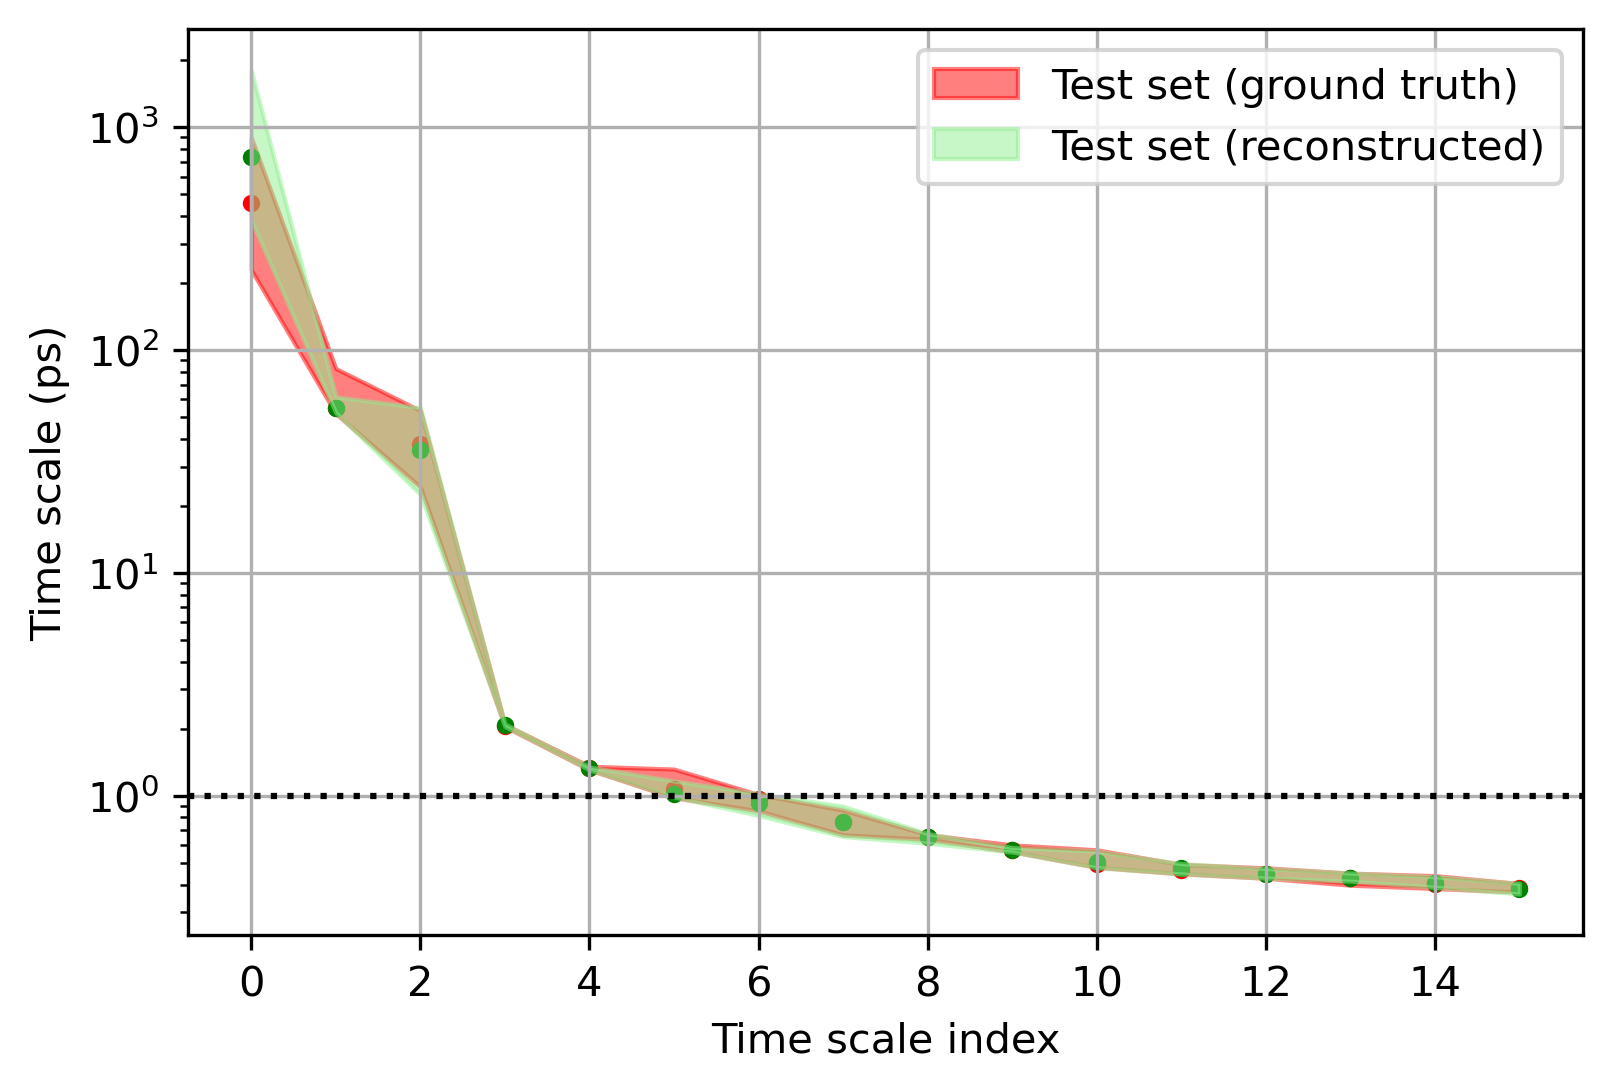

In [17]:
plt.figure(dpi=300)
plt.grid()

m = real_sample_mean
r =  real_sample_conf_r
l =  real_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='r')
plt.scatter(x, y, s=10, color='r')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='red', label='Test set (ground truth)')
plt.yscale('log')

m = fake_sample_mean
r =  fake_sample_conf_r
l =  fake_sample_conf_l

x = range(len(m))
y = m
y_h = r
y_l = l
#plt.plot(x, y, linestyle='--', color='g')
plt.scatter(x, y, s=10, color='g')
plt.fill_between(x, y_h, y_l, alpha=0.5, color='lightgreen', label='Test set (reconstructed)')
plt.yscale('log')

plt.axhline(1, linestyle=':', c='k')
plt.legend()
plt.xlabel('Time scale index')
plt.ylabel('Time scale (ps)')
plt.show()

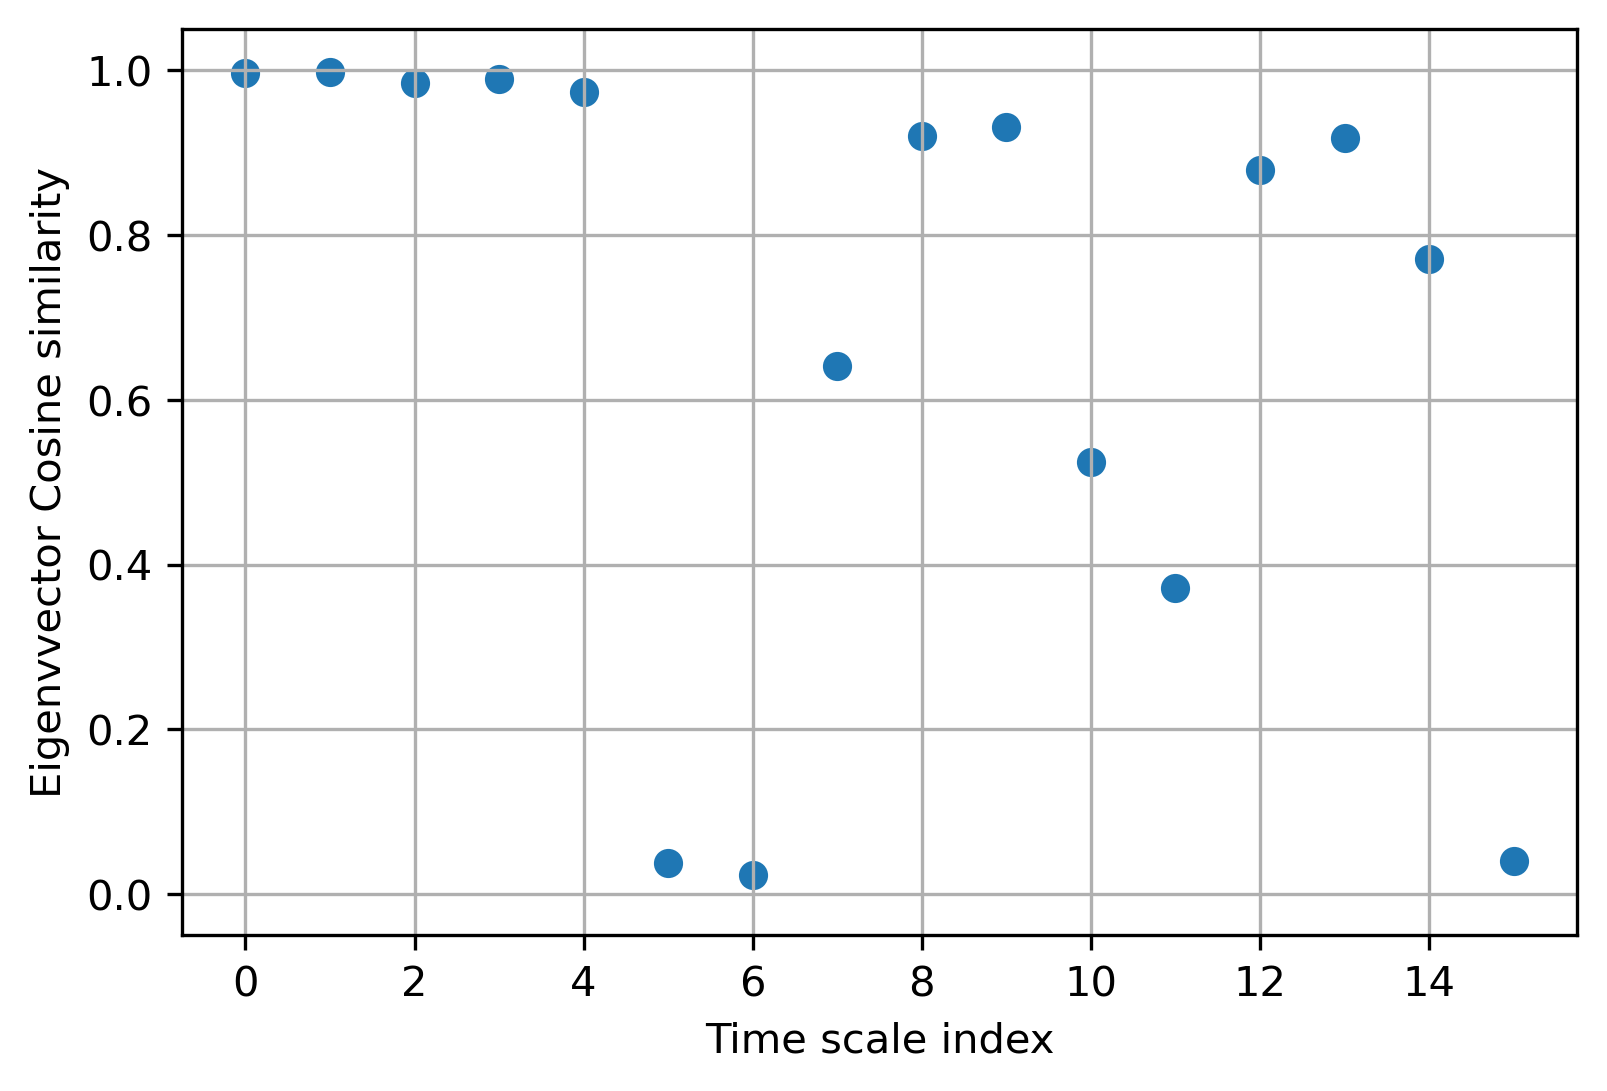

In [18]:
cosine_sims = list()
for i in range(1, num_timescales + 1):
    sim = abs(1 - cosine(evec_fake[dtrajs_fake, i], evec_real[dtrajs_real, i]))
    cosine_sims.append(sim)
plt.figure(dpi=300)
plt.grid()
plt.scatter(range(len(cosine_sims)), cosine_sims) 
plt.xlabel('Time scale index')
plt.ylabel('Eigenvvector Cosine similarity')
plt.ylim(-0.05, 1.05)
plt.show()